<div style="float:right;">
<ul>Owner:-
    <li>Name: Yash Ketan Kanakia</li>
    <li>Roll No: E21027</li>
</ul>
</div>

## Time Series Forecasting using Box-Jenkins Method

#### The model indicates 3 steps: model identification, parameter estimation and model validation.

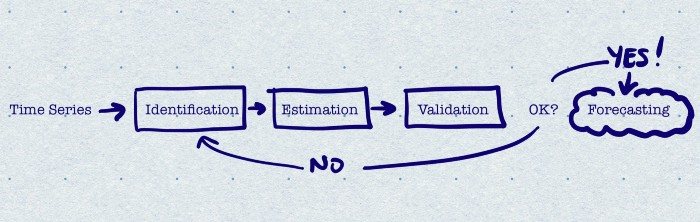

- The data is about monthly production of milk between 1962–1975.

In [129]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


# Read the Champagne dataset
df = pd.read_csv(r'C:\Users\Owner\Downloads\TF\Monthly Milk Production\monthly-milk-production.csv', sep=',',parse_dates=['Date'], index_col='Date')

In [130]:
df.head()

,Milk Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


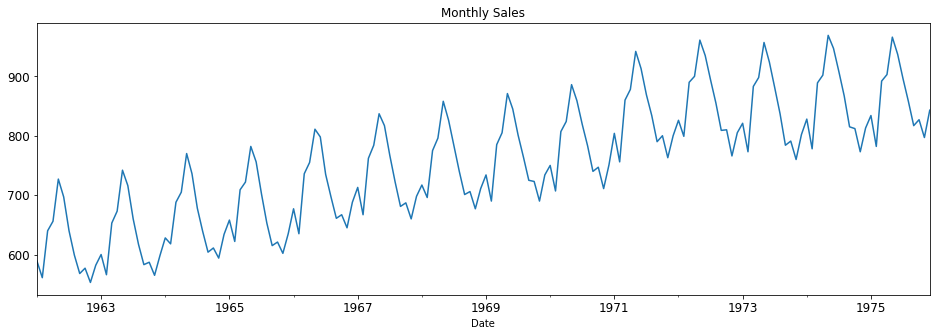

In [131]:
#Plotting data
df['Milk Production'].plot(figsize=(16,5), title= 'Monthly Sales', fontsize=12)
plt.show()

- The decomposition of time series is a statistical method to deconstruct time series into its <b>trend, seasonal and residual components</b>.

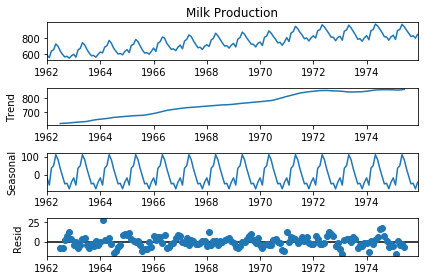

In [132]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk Production'], freq=12)
decomposition.plot()
plt.show()

## 1. Model Identification

- Checking whether time series is stationary, and if not, we need to understand what kind of transformation is required to make it stationary.

<Figure size 1152x360 with 0 Axes>

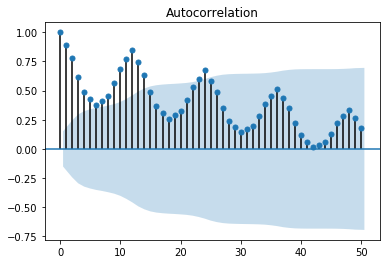

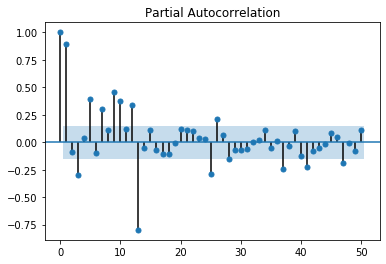

In [133]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure(figsize=(16,5))
plot_acf(df,lags=50)
plot_pacf(df,lags=50)
plt.show()

In [134]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Milk Production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


- P-value is greater than the threshold value, we fail to reject the null hypothesis and time series is non-stationary, it has time dependent component.

- All these approaches suggest we have non-stationary data

#### Due to both trend and seasonal components, we apply one non-seasonal diff() and one seasonal differencing diff(12).

In [135]:
df_diff = df.diff().diff(12).dropna()

<Figure size 1152x360 with 0 Axes>

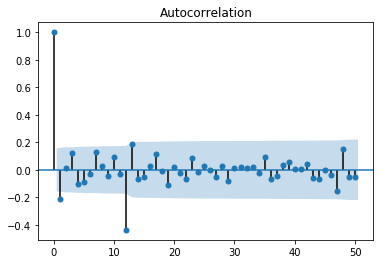

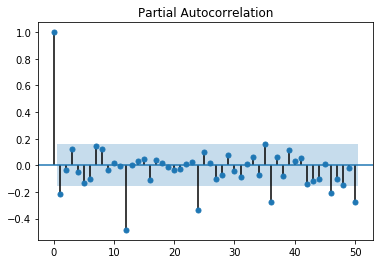

In [136]:
plt.figure(figsize=(16,5))
plot_acf(df_diff,lags=50)
plot_pacf(df_diff,lags=50)
plt.show()

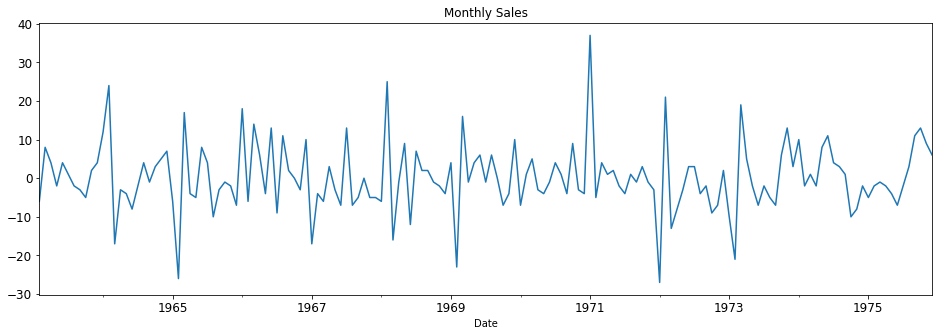

In [137]:
df_diff['Milk Production'].plot(figsize=(16,5), title= 'Monthly Sales', fontsize=12)
plt.show()

In [138]:
dftest = adfuller(df_diff['Milk Production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -5.038002
p-value                          0.000019
#Lags Used                      11.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


- P-value almost 0.00. which is lower than the threshold. All these checks suggest that differenced data is stationary.

<br>

- AR(p) is a regression model that utilizes the dependent relationship between an observation and some number of lagged observations.

- I(d) is the differencing order to make time series stationary.

- MA(q) is a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

## 2. Model Parameter Estimation

In [139]:
#Creating train and test set 
train = df.loc[:'1974-12-01']  #Creating a training dataset for learning
test = df.loc['1975-01-01':] #One year data for forecasting

In [140]:
import pmdarima as pm
model = pm.auto_arima(df['Milk Production'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1076.128, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1121.939, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1083.569, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1068.286, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1116.950, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1070.017, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1069.963, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1084.109, Time=0.57 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1074.277, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1070.056, Time=0.39 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1069.791, Time=0.33 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1068.200, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1116.800, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]

- SARIMAX function from statsmodel library 

In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Milk Production'],
                order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Milk Production   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -491.265
Date:                              Thu, 12 Aug 2021   AIC                            988.530
Time:                                      23:45:40   BIC                            997.419
Sample:                                  01-01-1962   HQIC                           992.142
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2512      0.081     -3.093      0.002      -0.410      -0.092
ma.S.L12      -0.6090      0.078     -7.858      0.000      -0.761      -0.457
sigma2        54.2523      5.266     10.303      0.000      43.931      64.573
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                38.09
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.79
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. Model Validation

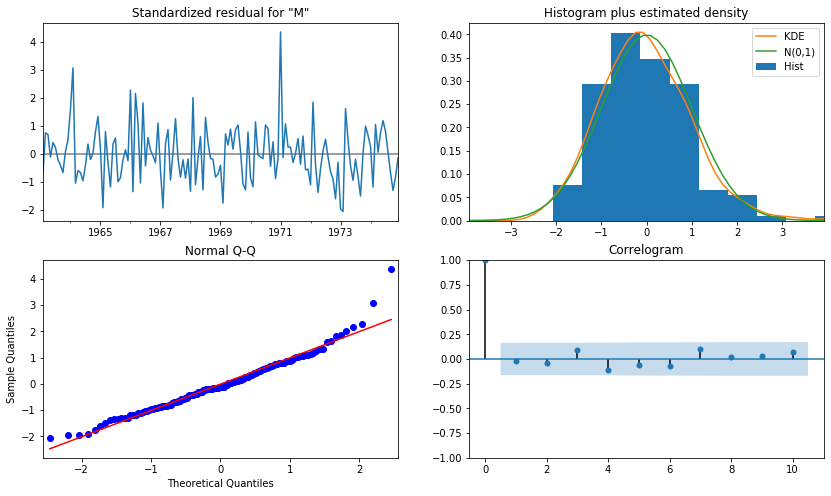

In [142]:
results.plot_diagnostics(figsize=(14,8))
plt.show()

- The top-left plot shows the residuals over time and it appears to be a white noise with no seasonal component.
- The top-right plot shows that kde line (in red) closely follows the N(0,1) line, which is the standard notation of normal distribution with zero mean and standard deviation of 1, suggesting the residuals are normally distributed.
- The bottom-left normal QQ-plot shows ordered distribution of residuals (in blue) closely follow the linear trend of the samples taken from a standard normal distribution, suggesting residuals are normally distributed.
- The bottom-right is a correlogram plot indicating residuals have a low correlation with lagged versions.

<br/>

- Measure the accuracy of forecasts, we compare the prediction values on the test set with its real values.

In [143]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

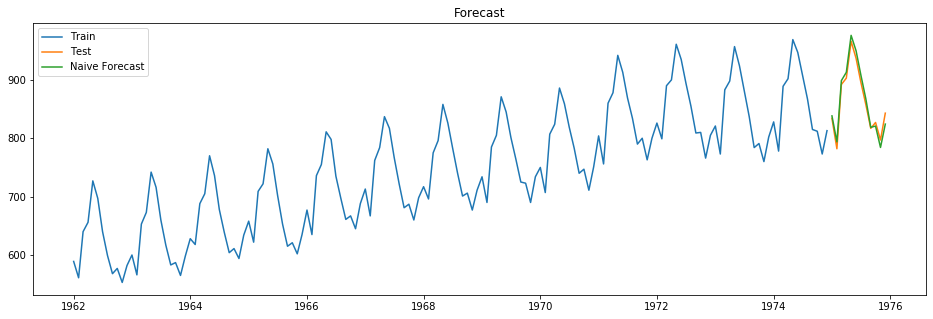

In [144]:
plt.figure(figsize=(16,5))
plt.plot(train.index, train['Milk Production'], label='Train')
plt.plot(test.index,test['Milk Production'], label='Test')
plt.plot(mean.index,mean.values, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Forecast")
plt.show()

In [145]:
from sklearn.metrics import r2_score
r2_score(test['Milk Production'], mean.values)

0.9609044124638634

The <b>R squared</b> of the model is 0.96, indicating that the coefficient of determination of the model is 96%.

In [146]:
mean_absolute_percentage_error = np.mean(np.abs(mean.values - test['Milk Production'])/np.abs(test['Milk Production']))*100
mean_absolute_percentage_error

1.1348399336545365

The <b>MAPE score</b> of the model equals to 1.13, indicating the forecast is off by 1.64% and 98.87% accurate.

<br/>

### The forecast for the next 24 months.

In [147]:
forecast = results.get_forecast(steps=24)
mean_forecast = forecast.predicted_mean

confidence_intervals = forecast.conf_int()

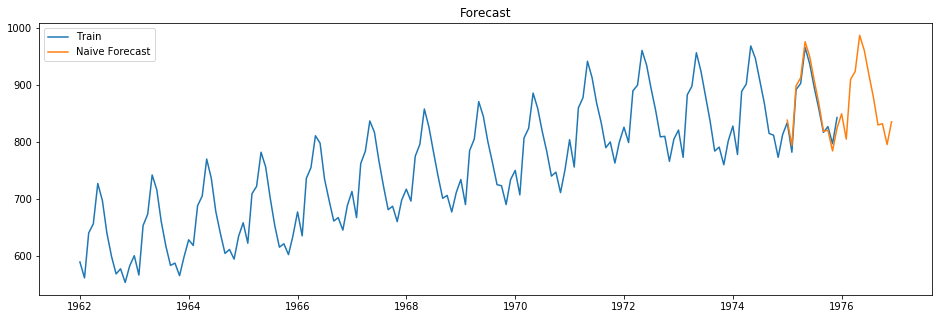

In [148]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df['Milk Production'], label='Train')
plt.plot(mean_forecast.index,mean_forecast.values, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Forecast")
plt.show()